In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [3]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [5]:
import os
import time
import random
import shutil

In [6]:
import cv2

In [7]:
import scipy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

In [8]:
from sklearn.metrics import classification_report,confusion_matrix

In [9]:
root = os.getcwd()
root

'C:\\Personal\\Local\\Coding\\Projects\\AI\\physics-classification'

### Label (Tag) the Frames

In [10]:
labels = ['FreeFall', 'Sound_vs_Fire']
img_size = 224

def get_data(data_dir):
    data = []
    for l in labels:
        path = os.path.join(data_dir, l)
        num_class = labels.index(l)
        for img in os.listdir(path):
            try:
                arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resize_arr = cv2.resize(arr, (img_size, img_size))
                data.append([resize_arr, num_class])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [11]:
data = get_data(os.path.join(root, 'data'))
data

array([[array([[ 49,  49,  49, ...,  86,  86,  86],
               [ 49,  49,  49, ...,  87,  86,  86],
               [ 47,  51,  48, ..., 143, 152, 152],
               ...,
               [  4,   5,   5, ...,  75, 101, 102],
               [  3,   4,   2, ...,  72, 100,  99],
               [  3,   3,   3, ...,  68, 100, 100]], dtype=uint8), 0],
       [array([[ 49,  46,  50, ...,  85,  84,  84],
               [ 47,  49,  49, ...,  85,  86,  86],
               [ 49,  49,  48, ..., 123, 126, 125],
               ...,
               [  4,   3,   3, ...,  72, 101, 100],
               [  4,   4,   3, ...,  72, 101, 102],
               [  3,   3,   3, ...,  73,  99,  97]], dtype=uint8), 0],
       [array([[ 47,  48,  48, ...,  84,  85,  85],
               [ 49,  49,  49, ...,  86,  86,  86],
               [ 49,  50,  50, ...,  60,  60,  60],
               ...,
               [  3,   2,   2, ..., 104, 100,  72],
               [  2,   3,   2, ..., 104,  97,  70],
               [  

In [12]:
len(data)

23353

### Data Visualization

<Axes: xlabel='count'>

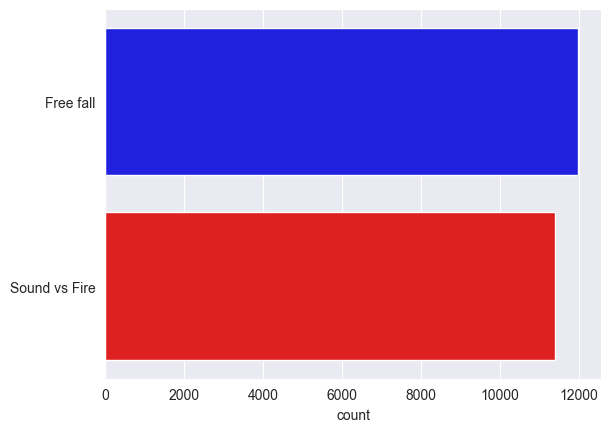

In [13]:
label = []
for i in data:
    if (i[1]==0):
        label.append('Free fall')
    else:
        label.append('Sound vs Fire')
sns.set_style('darkgrid')
sns.countplot(label, palette=['blue', 'red'])

Text(0.5, 1.0, 'Sound_vs_Fire')

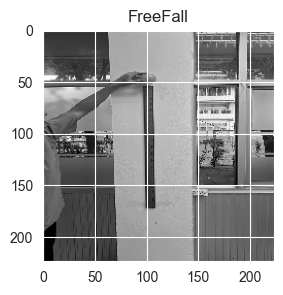

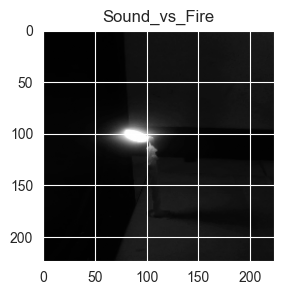

In [14]:
plt.figure(figsize = (3, 3))
plt.imshow(data[0][0], cmap='gray')
plt.title(labels[data[0][1]])

plt.figure(figsize = (3, 3))
plt.imshow(data[-1][0], cmap='gray')
plt.title(labels[data[-1][1]])

### Split into Train / Validation / Test Sets

In [15]:
ratio = {'train': 0.75, 'test': 0.15, 'val': 0.10}
n = len(data)
num = [int(n*ratio['train']), int(n*ratio['test']), int(n*ratio['val'])]

train = []
test = []
val = []

# train
for i in range(0, num[0]):
    r = random.randint(0, n-1)
    train.append(data[r])
    np.delete(data, r)

# test
for i in range(0, num[1]):
    r = random.randint(0, n-1)
    test.append(data[r])
    np.delete(data, r)

# val
for i in range(0, num[2]):
    r = random.randint(0, n-1)
    val.append(data[r])
    np.delete(data, r)

len(train), len(test), len(val), len(train)+len(test)+len(val)

(17514, 3502, 2335, 23351)

In [16]:
x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [17]:
x_train = np.array(x_train, dtype='e') / 255

In [18]:
x_val = np.array(x_val, dtype='e') / 255

In [19]:
x_test = np.array(x_test, dtype='e') / 255

In [20]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [21]:
x_train.shape

(17514, 224, 224, 1)

In [22]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 60,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.35, # Randomly zoom image 
        width_shift_range=0.35,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.35,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### Build a model

In [23]:
model = Sequential()
model.add(Conv2D(64, (3, 3), strides=3, padding='same', activation='relu', input_shape=(224, 224, 1)))
model.add(Conv2D(64, (3,3), strides=3, padding='same', activation='relu'))
model.add(MaxPool2D((3, 3), strides=3, padding='same'))
model.add(Conv2D(128, (3, 3), strides=3, padding='same', activation='relu'))
model.add(MaxPool2D((3, 3), strides=3, padding='same'))
model.add(Conv2D(256, (3, 3), strides=3, padding='same', activation='relu'))
model.add(MaxPool2D((3, 3), strides=3, padding='same'))
model.add(Conv2D(512, (3, 3), strides=3, padding='same', activation='relu'))
model.add(MaxPool2D((3, 3), strides=3, padding='same'))
model.add(Flatten())
model.add(Dense(units = 1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units = 1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation='sigmoid'))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 75, 75, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 25, 25, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 1, 1, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 1, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,170,881 (12.10 MB)

 Trainable params: 3,166,785 (12.08 MB)

 Non-trainable params: 4,096 (16.00 KB)

### Compile and Train the Model

In [24]:
start = time.time()
history = model.fit(datagen.flow(x_train,y_train, batch_size = 16) ,epochs = 5 , validation_data = datagen.flow(x_val, y_val))
end = time.time()

Epoch 1/5
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 133s 118ms/step - accuracy: 0.9823 - loss: 0.0557 - val_accuracy: 0.4779 - val_loss: 1.3868
Epoch 2/5
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 130s 119ms/step - accuracy: 0.9965 - loss: 0.0148 - val_accuracy: 1.0000 - val_loss: 2.9285e-04
Epoch 3/5
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 131s 119ms/step - accuracy: 0.9986 - loss: 0.0060 - val_accuracy: 0.9987 - val_loss: 0.0054
Epoch 4/5
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 126s 115ms/step - accuracy: 0.9986 - loss: 0.0072 - val_accuracy: 0.9996 - val_loss: 0.0012
Epoch 5/5
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 129s 117ms/step - accuracy: 0.9992 - loss: 0.0037 - val_accuracy: 0.9996 - val_loss: 0.0023


In [25]:
print((end-start)/3600)

0.18076008399327595


### Evaluate on Test Set

In [26]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 1.0000 - loss: 3.2045e-07
Loss of the model is -  3.21796591151724e-07
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 1.0000 - loss: 3.2045e-07
Accuracy of the model is -  100.0 %


### Analyze Results

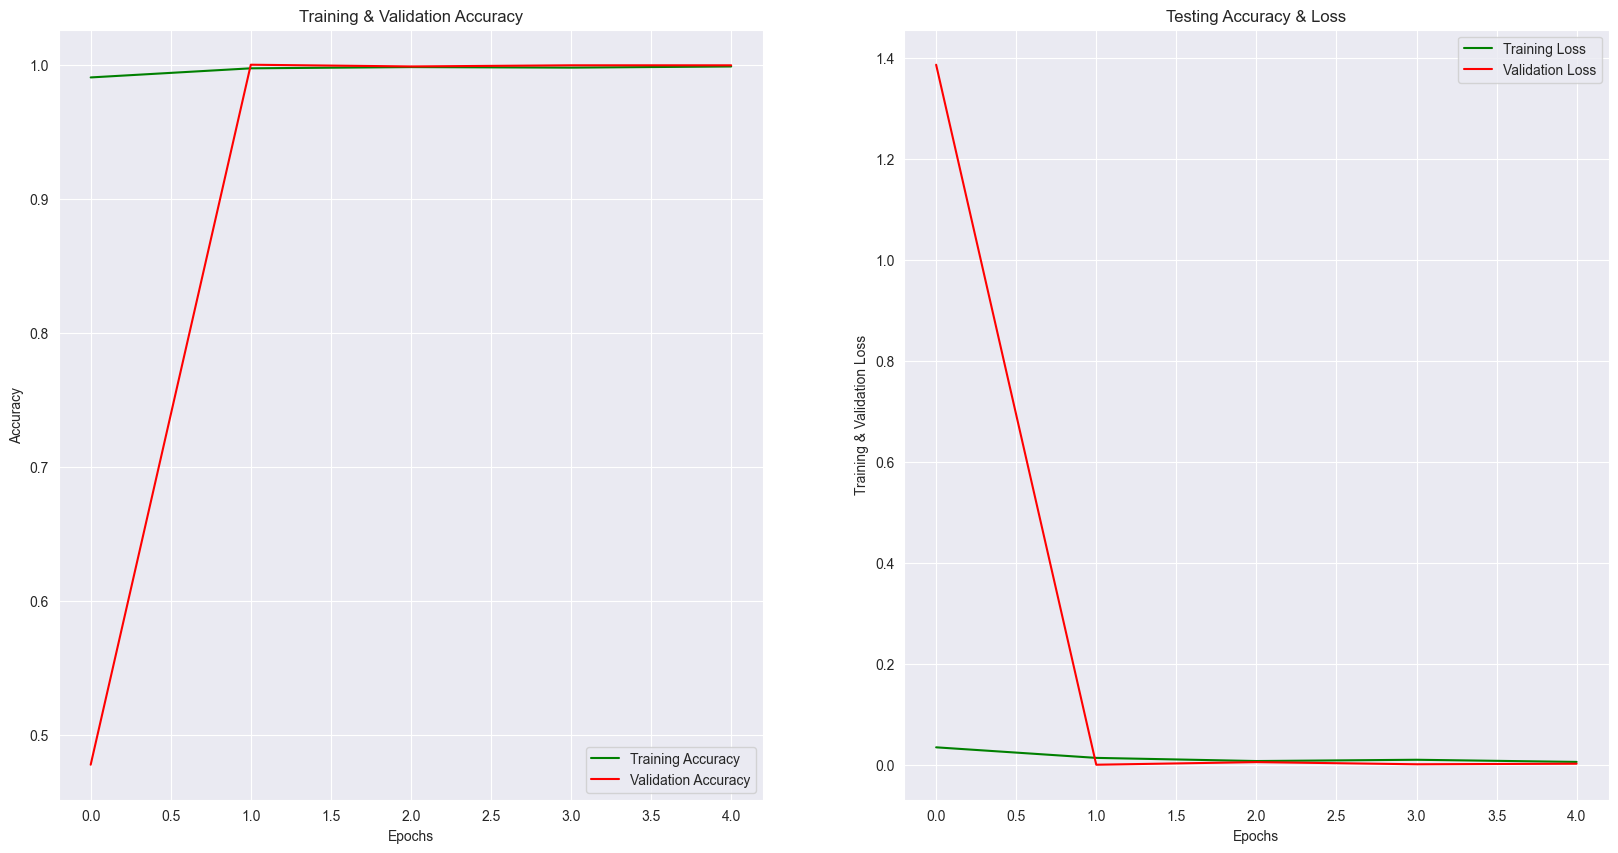

In [27]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'g' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [28]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions = np.where(predictions>0.5, 1, 0)
predictions

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


array([0, 0, 0, ..., 1, 1, 0])

In [29]:
print(classification_report(y_test, predictions, target_names = ['Free fall (Class 0)','Sound vs Fire (Class 1)']))

                         precision    recall  f1-score   support

    Free fall (Class 0)       1.00      1.00      1.00      1773
Sound vs Fire (Class 1)       1.00      1.00      1.00      1729

               accuracy                           1.00      3502
              macro avg       1.00      1.00      1.00      3502
           weighted avg       1.00      1.00      1.00      3502



In [30]:
cm = confusion_matrix(y_test,predictions)
cm

array([[1773,    0],
       [   0, 1729]])

In [31]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

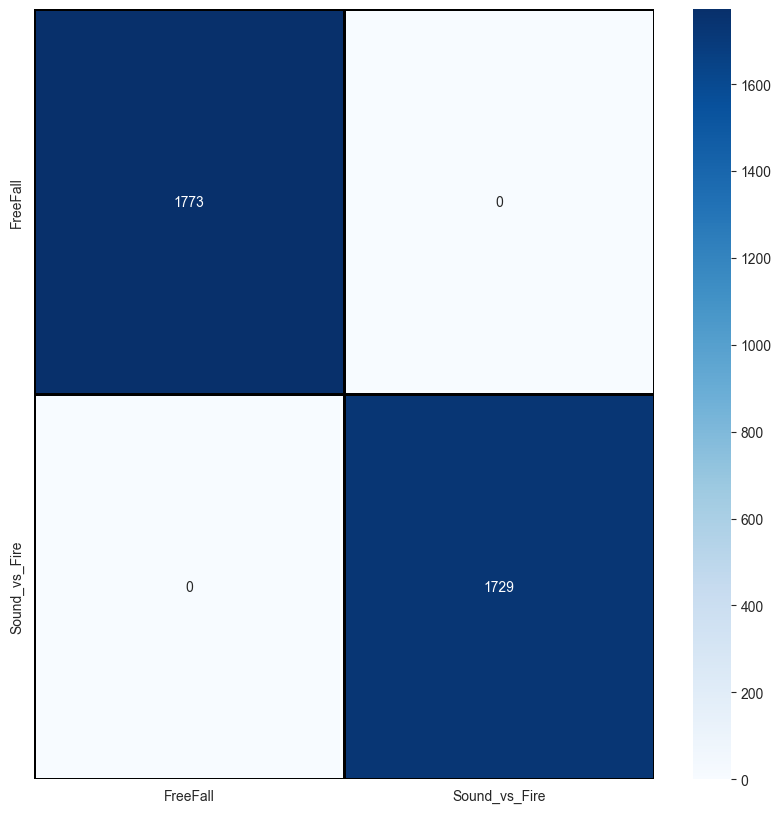

In [32]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [33]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

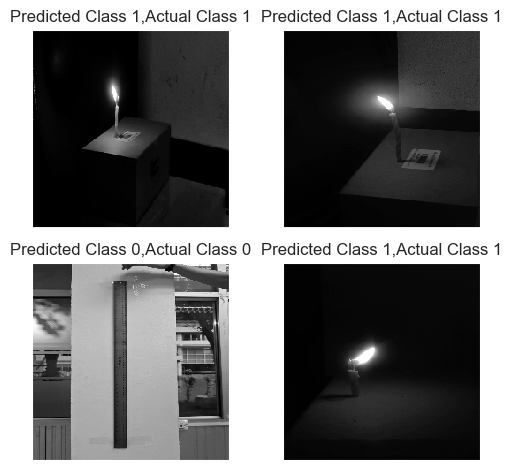

In [34]:
i = 0
for c in correct[99:103]:
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(224,224), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [35]:
i = 0
for c in incorrect[:4]:
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(224,224), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

### Test with unseen problems

In [36]:
# Extract frames

def extract_frames(source, dest):
    if not os.path.exists(dest):
        os.makedirs(dest)

    cap = cv2.VideoCapture(source)
    count = 0

    while True:
        success, image = cap.read()
        if not success:
            break

        frame_path = os.path.join(dest, f"{count}.png")
        cv2.imwrite(frame_path, image)
        count += 1

    cap.release()

In [37]:
unseen_path = os.path.join(root, 'unseen')
unseen_path

'C:\\Personal\\Local\\Coding\\Projects\\AI\\physics-classification\\unseen'

In [38]:
unseen_list = os.listdir(unseen_path)
unseen_list

['1739800161844.mp4',
 '20250714_184608.mp4',
 '20250714_184641.mp4',
 '20250714_184912.mp4',
 '20250714_190007.mp4',
 '20250715_163752.mp4',
 '20250715_164224.mp4',
 '20250715_164549.mp4',
 '20250715_164951.mp4',
 '20250715_165100.mp4',
 'Screen Recording 2025-07-31 003150.mp4',
 'Screen Recording 2025-07-31 004053.mp4',
 'typt2025-fire-70hz.mp4']

In [39]:
len(unseen_list)

13

In [40]:
unseen_extract_path = []
for i in range(0, len(unseen_list)):
    path = os.path.join(unseen_path, str(i), unseen_list[i])
    unseen_extract_path.append(path)

unseen_extract_path

['C:\\Personal\\Local\\Coding\\Projects\\AI\\physics-classification\\unseen\\0\\1739800161844.mp4',
 'C:\\Personal\\Local\\Coding\\Projects\\AI\\physics-classification\\unseen\\1\\20250714_184608.mp4',
 'C:\\Personal\\Local\\Coding\\Projects\\AI\\physics-classification\\unseen\\2\\20250714_184641.mp4',
 'C:\\Personal\\Local\\Coding\\Projects\\AI\\physics-classification\\unseen\\3\\20250714_184912.mp4',
 'C:\\Personal\\Local\\Coding\\Projects\\AI\\physics-classification\\unseen\\4\\20250714_190007.mp4',
 'C:\\Personal\\Local\\Coding\\Projects\\AI\\physics-classification\\unseen\\5\\20250715_163752.mp4',
 'C:\\Personal\\Local\\Coding\\Projects\\AI\\physics-classification\\unseen\\6\\20250715_164224.mp4',
 'C:\\Personal\\Local\\Coding\\Projects\\AI\\physics-classification\\unseen\\7\\20250715_164549.mp4',
 'C:\\Personal\\Local\\Coding\\Projects\\AI\\physics-classification\\unseen\\8\\20250715_164951.mp4',
 'C:\\Personal\\Local\\Coding\\Projects\\AI\\physics-classification\\unseen\\9\\2025

In [41]:
for i in range(0, len(unseen_list)):
    source = os.path.join(unseen_path, unseen_list[i])
    dest = unseen_extract_path[i]
    extract_frames(source, dest)
    print('Extract', i, unseen_list[i], '✅')

Extract 0 1739800161844.mp4 ✅
Extract 1 20250714_184608.mp4 ✅
Extract 2 20250714_184641.mp4 ✅
Extract 3 20250714_184912.mp4 ✅
Extract 4 20250714_190007.mp4 ✅
Extract 5 20250715_163752.mp4 ✅
Extract 6 20250715_164224.mp4 ✅
Extract 7 20250715_164549.mp4 ✅
Extract 8 20250715_164951.mp4 ✅
Extract 9 20250715_165100.mp4 ✅
Extract 10 Screen Recording 2025-07-31 003150.mp4 ✅
Extract 11 Screen Recording 2025-07-31 004053.mp4 ✅
Extract 12 typt2025-fire-70hz.mp4 ✅


In [42]:
img_size = 224

def convert_to_gray(data_dir, i):
    data = []
    p = os.path.join(data_dir, str(i))
    d = os.listdir(p)
    for j in d: # Dir
        temp = os.path.join(p, j)
        for k in os.listdir(temp): # Image list
            path = os.path.join(temp, k)
            #print(path)

            try:
                a = cv2.imread(os.path.join(path), cv2.IMREAD_GRAYSCALE)
                resize_arr = cv2.resize(a, (img_size, img_size))
                data.append(resize_arr)
            except Exception as e:
                print(e)
    return np.array(data, dtype='e')

In [43]:
def stack(dir_path):
    stk = []
    for i in range(len(unseen_list)):
        u = convert_to_gray(dir_path, i)
        u = u/255
        u = u.reshape(-1, img_size, img_size, 1)
        stk.append(u)
    return stk

In [44]:
unseen = stack(unseen_path)

In [45]:
print(f'Dim: ({len(unseen)}, {len(unseen[0])}, {len(unseen[0][0])}, {len(unseen[0][1])})')

Dim: (13, 1134, 224, 224)


In [46]:
unseen[0][0].shape

(224, 224, 1)

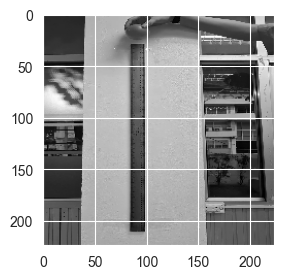

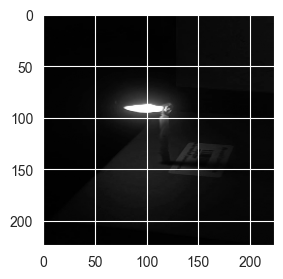

In [47]:
plt.figure(figsize = (3, 3))
plt.imshow(unseen[1][0], cmap='gray')

plt.figure(figsize = (3, 3))
plt.imshow(unseen[-1][0], cmap='gray')

In [48]:
def predict_class(test_case):
    labels = ['Free fall', 'Sound vs Fire']
    pred = model.predict(test_case)
    pred = pred.reshape(1,-1)[0]
    pred = np.where(pred>0.5, 1, 0)

    values, c = np.unique(pred, return_counts=True)
    most = values[np.argmax(c)]
    l = labels[most]
    return l

In [49]:
def display_video(path):
    # Create a named window that can be resized
    cv2.namedWindow("frame", cv2.WINDOW_NORMAL)

    # Set the desired window size (e.g., 800x600 pixels)
    cv2.resizeWindow("frame", 800, 600)
    
    cap = cv2.VideoCapture(path)

    while (cap.isOpened()):
        r, f = cap.read()
        if r==True:
            cv2.imshow('frame', f)

            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break
    cap.release()
    cv2.destroyAllWindows()

In [50]:
path = os.path.join(unseen_path, unseen_list[0])
display_video(path)

In [51]:
p0 = predict_class(unseen[0])
p0

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


'Sound vs Fire'

In [52]:
path = os.path.join(unseen_path, unseen_list[1])
display_video(path)

In [53]:
p1 = predict_class(unseen[1])
p1

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


'Free fall'

In [62]:
path = os.path.join(unseen_path, unseen_list[10])
display_video(path)

In [63]:
p10 = predict_class(unseen[10])
p10

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


'Sound vs Fire'

In [56]:
path = os.path.join(unseen_path, unseen_list[11])
display_video(path)

In [57]:
p11 = predict_class(unseen[11])
p11

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


'Free fall'

In [58]:
model.save('Model2.h5')

In [59]:
model.save('Model2.keras')

In [60]:
new_model = tf.keras.models.load_model('Model2.keras')

In [61]:
print("Loss of the model is - " , new_model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , new_model.evaluate(x_test,y_test)[1]*100 , "%")

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 1.0000 - loss: 3.2045e-07
Loss of the model is -  3.21796591151724e-07
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 3.2045e-07
Accuracy of the model is -  100.0 %
